# Building a GAN with PyTorch

In [313]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

### Configurations

In [314]:
import torch.backends

torch.set_default_device("mps:0")
device = "mps:0" # device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# device = 'cpu'

batch_size = 128
noise_dim = 64


#### Optimizer parameters

In [315]:
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.99

#### Training variables

In [316]:
epochs = 20

## Load MNIST Dataset

In [317]:
from torchvision import datasets, transforms as T

In [318]:
train_augs = T.Compose([T.RandomRotation((-20, 20)),
                        T.ToTensor(), #Images need to be in channel, height, width format
])

In [319]:
trainset = datasets.MNIST(root='/Users/akshaya/Projects/DATASETS/MNIST/', train=True, download=False, transform=train_augs)

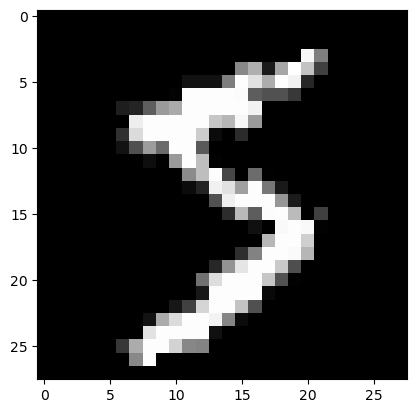

In [320]:
image, label = trainset[0]
plt.imshow(image.squeeze(), cmap='gray')

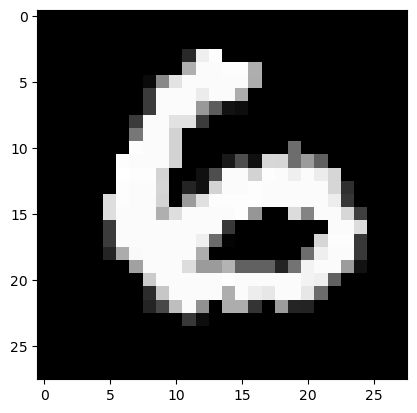

In [321]:
image, label = trainset[9000]
plt.imshow(image.squeeze(), cmap='gray')

In [322]:
print("Total number of images present on trainset from MNIST dataset: ", len(trainset))

Total number of images present on trainset from MNIST dataset:  60000


## Load Dataset into Batches 

In [323]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [324]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=False)#, generator=torch.Generator(device=device))

In [325]:
print("Total number of batches present in trainloader: ", len(trainloader))

Total number of batches present in trainloader:  469


In [326]:
dataiter = iter(trainloader)
images, _ = next(dataiter)
print(images.shape)

torch.Size([128, 1, 28, 28])


In [327]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

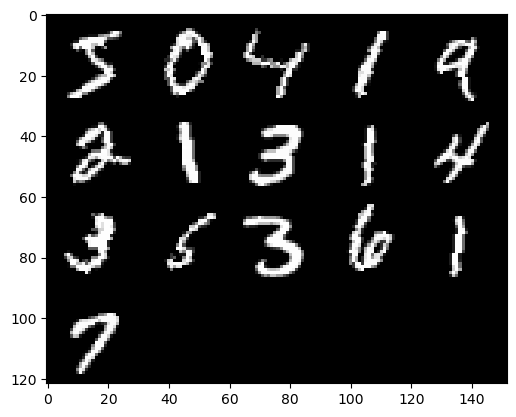

In [328]:
show_tensor_images(images, num_images=16)

## Create Discriminator Network

In [329]:
from torch import nn
from torchsummary import summary

Discriminator network structure:

1. Input
2. Conv2d, BatchNorm2d, LeakyReLU
3. Conv2d, BatchNorm2d, LeakyReLU
4. Conv2d, BatchNorm2d, LeakyReLU
5. Flatten
6. Linear Output

In [330]:
def get_disc_block(input_channels, output_channels, kernel_size, stride=2):
    return nn.Sequential(
        nn.Conv2d(input_channels, output_channels, kernel_size, stride=2),
        nn.BatchNorm2d(output_channels),
        nn.LeakyReLU(0.2)
    )

In [331]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.block_1 = get_disc_block(1, 16, (3,3), 2)
        self.block_2 = get_disc_block(16, 32, (5,5), 2)
        self.block_3 = get_disc_block(32, 64, (5,5), 2)

        self.flatten = nn.Flatten()
        self.linear = nn.Linear(in_features=64, out_features=1)
    
    def forward(self, images):
        
        x1 = self.block_1(images.to(device))
        x2 = self.block_2(x1)
        x3 = self.block_3(x2)
        
        x4 = self.flatten(x3)
        x5 = self.linear(x4)

        return x5

In [332]:
D = Discriminator().to(device)

summary(D, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

## Create Generator Network

Generator network strutcure:

1. Input : Random noise, channel, height, width
2. ConvTranspose2d, BatchNorm2d, ReLu
3. ConvTranspose2d, BatchNorm2d, ReLu
4. ConvTranspose2d, BatchNorm2d, ReLu
5. ConvTranspose2d
6. Tanh

In [333]:
def get_gen_block(input_channels, output_channels, kernel_size, stride=2, final_block=False):
    if final_block == True:
        return nn.Sequential(
            nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
            nn.Tanh()
        )
    return nn.Sequential(
        nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
        nn.BatchNorm2d(output_channels),
        nn.ReLU()
    )

In [334]:
class Generator(nn.Module):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()

        self.noise_dim = noise_dim
        self.block1 = get_gen_block(noise_dim, 256, (3,3), 2)
        self.block2 = get_gen_block(256, 128, (4,4), 1)
        self.block3 = get_gen_block(128, 64, (3,3), 2)

        self.block4 = get_gen_block(64, 1, (4,4), 2, final_block=True)

    def forward(self, random_noise_vec):

        #(bs, noise_dim) -> (bs, noise_dim, 1, 1)

        x = random_noise_vec.view(-1, self.noise_dim, 1, 1)
        x1 = self.block1(x)
        x2 = self.block2(x1)
        x3 = self.block3(x2)
        x4 = self.block4(x3)

        return x4


In [335]:
G = Generator(noise_dim)

In [336]:
G_cpu = G.to('cpu')
summary(G_cpu, input_size=(1, noise_dim)) # Because ConvTranspose2d of the summary function is not supported on mps device
G = G.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [337]:
# Replace randomly initialized weights with normal weights
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [338]:
D = D.apply(weights_init)   
G = G.apply(weights_init)

## Create Loss Function and Load Optimizer

In [339]:
def real_loss(disc_pred):
    criterion = nn.BCEWithLogitsLoss()
    ground_truth = torch.ones_like(disc_pred)
    loss = criterion(disc_pred, ground_truth)
    return loss

def fake_loss(disc_pred):
    criterion = nn.BCEWithLogitsLoss()
    ground_truth = torch.zeros_like(disc_pred)
    loss = criterion(disc_pred, ground_truth)
    return loss

In [340]:
D_opt = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta_1, beta_2))
G_opt = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta_1, beta_2))

## Training Loop

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.83447593..0.9937681].


Epoch : 1 | D_loss : 0.6508735418319702 | G_loss : 0.7506725589857935


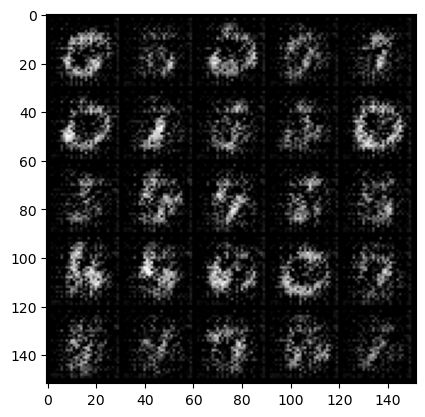

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8836172..0.9998].


Epoch : 2 | D_loss : 0.5985829830169678 | G_loss : 0.8210351568803604


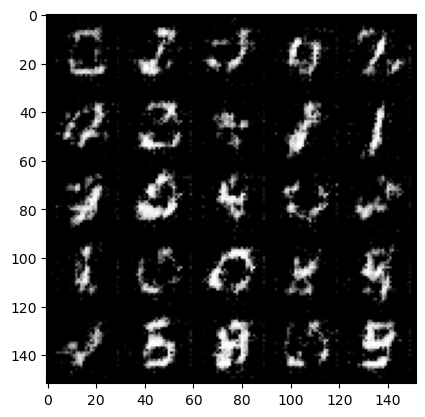

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9061454..0.9999737].


Epoch : 3 | D_loss : 0.5695601105690002 | G_loss : 0.8810976053605964


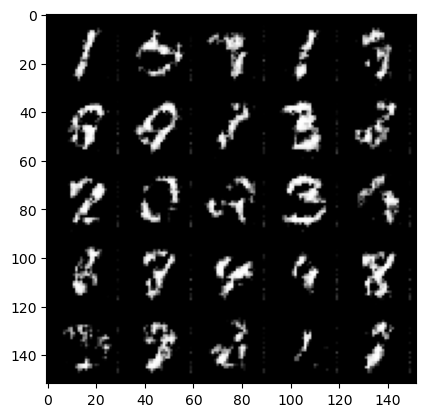

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.95987785..1.0].


Epoch : 4 | D_loss : 0.5591239333152771 | G_loss : 0.9170198393528903


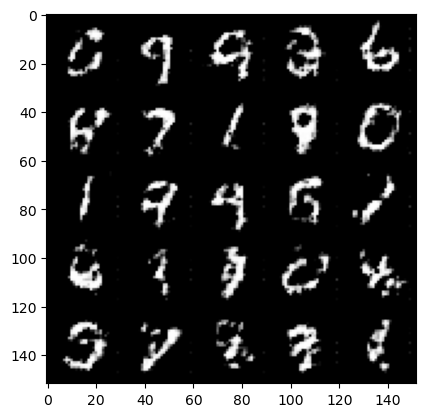

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9908582..1.0].


Epoch : 5 | D_loss : 0.5577831268310547 | G_loss : 0.9347060853992698


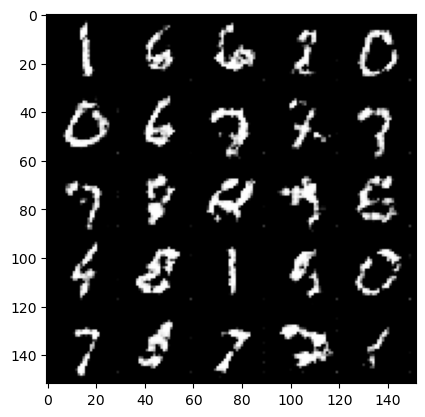

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9946831..1.0].


Epoch : 6 | D_loss : 0.5622730851173401 | G_loss : 0.9384460754231858


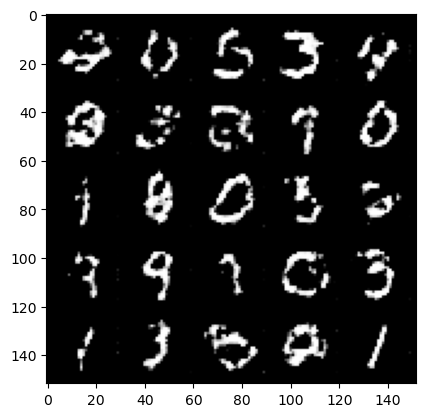

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99789625..1.0].


Epoch : 7 | D_loss : 0.568589448928833 | G_loss : 0.9377741016812925


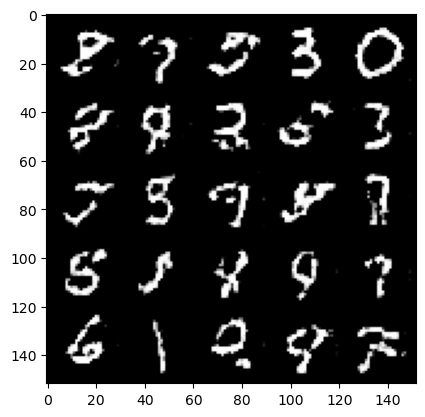

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9998948..1.0].


Epoch : 8 | D_loss : 0.5766034126281738 | G_loss : 0.9347046721718713


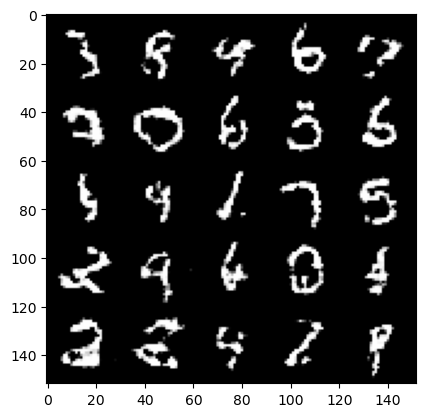

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99996084..1.0].


Epoch : 9 | D_loss : 0.5818628668785095 | G_loss : 0.9331716784536203


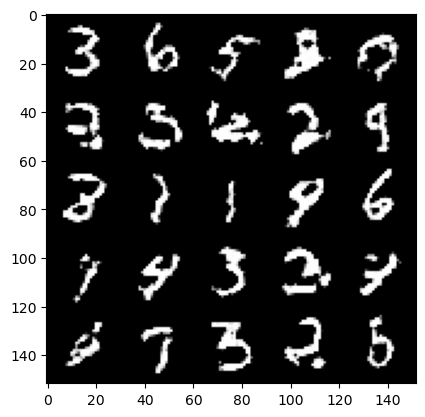

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9999977..1.0].


Epoch : 10 | D_loss : 0.5859807729721069 | G_loss : 0.928632084367626


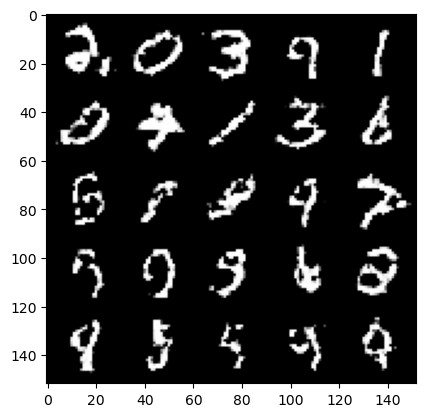

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9999688..1.0].


Epoch : 11 | D_loss : 0.5900484323501587 | G_loss : 0.9253693952489255


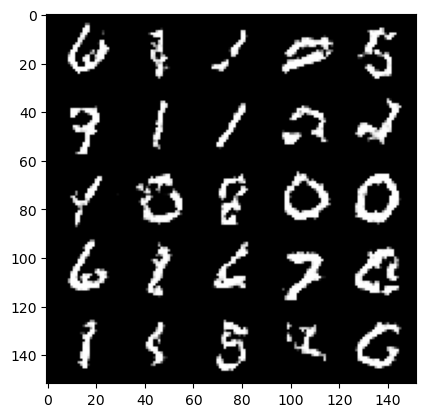

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99992305..1.0].


Epoch : 12 | D_loss : 0.4652354121208191 | G_loss : 1.1708558679643724


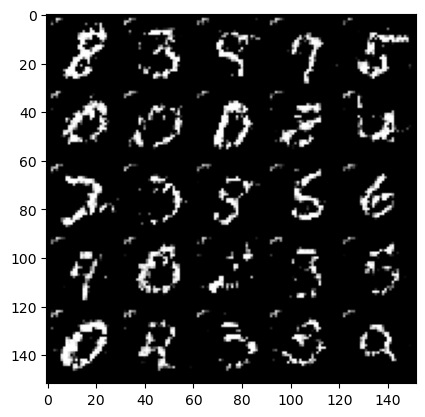

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9999922..0.9993752].


Epoch : 13 | D_loss : 0.2891988456249237 | G_loss : 1.615604850020744


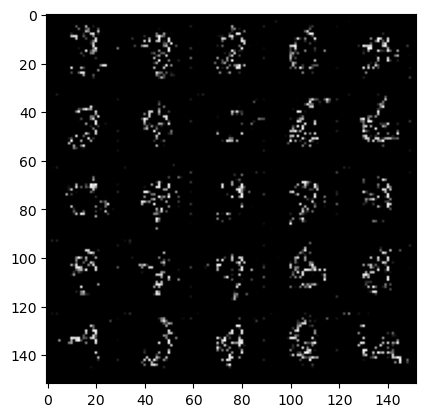

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.997946..0.7556645].


Epoch : 14 | D_loss : 0.2908713221549988 | G_loss : 1.69764856183961


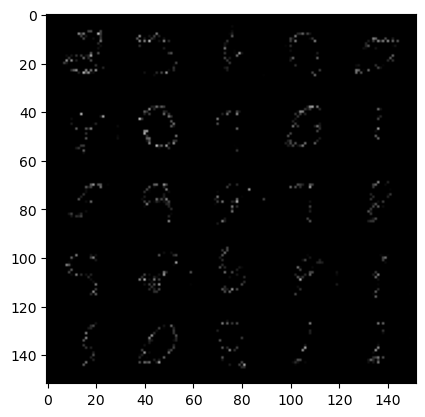

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9969633..0.85072625].


Epoch : 15 | D_loss : 0.40670159459114075 | G_loss : 1.3673285963947077


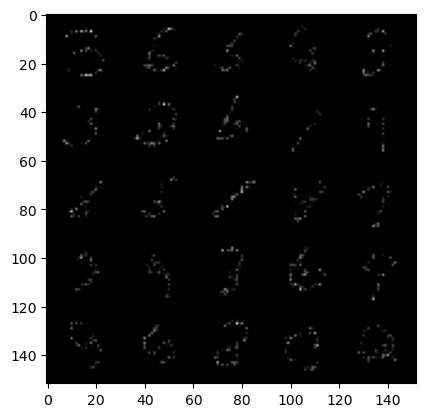

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99724996..0.8769062].


Epoch : 16 | D_loss : 0.43205246329307556 | G_loss : 1.3184622950645397


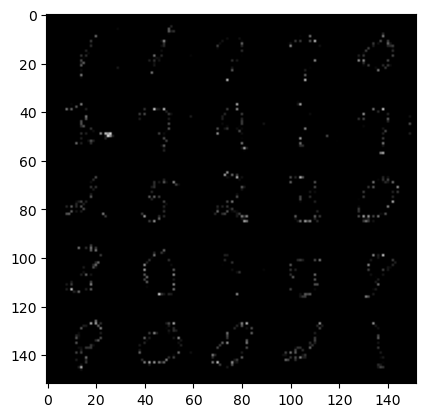

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9983577..0.823211].


Epoch : 17 | D_loss : 0.4507982134819031 | G_loss : 1.2988185634745208


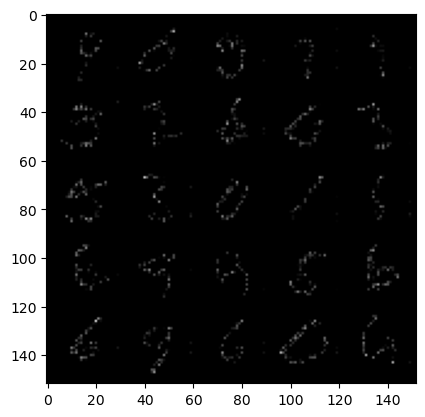

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99400526..0.7787447].


Epoch : 18 | D_loss : 0.4579584002494812 | G_loss : 1.2902718579082855


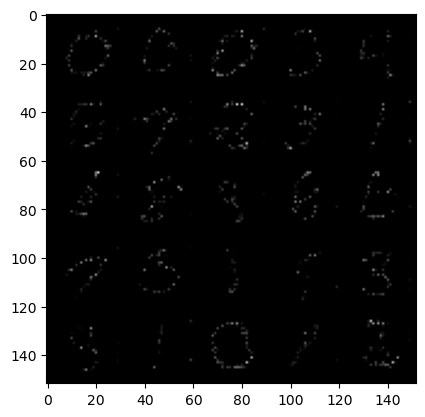

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9949087..0.7705421].


Epoch : 19 | D_loss : 0.47102293372154236 | G_loss : 1.2675171341977394


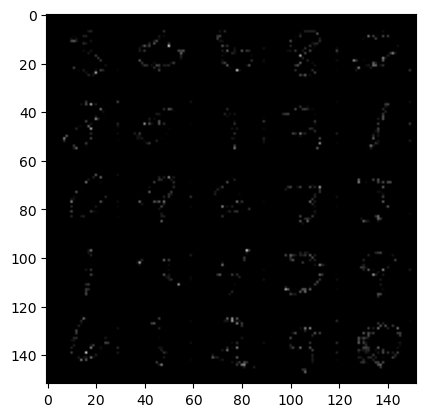

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9976486..0.7641798].


Epoch : 20 | D_loss : 0.4783940315246582 | G_loss : 1.2528168102825628


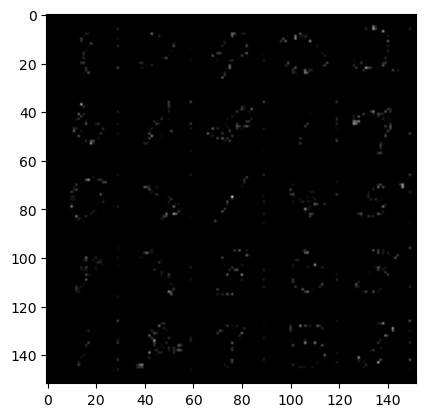

In [341]:
for i in range(epochs):
    total_d_loss = 0.0
    total_g_loss = 0.0

    for real_img, _ in tqdm(trainloader):
        real_img = real_img.to(device)
        noise = torch.randn(batch_size, noise_dim).to(device)

        # find loss and update weights for Discriminator network
        D_opt.zero_grad()
        fake_img = G(noise)
        D_pred = D(fake_img)
        D_fake_loss = fake_loss(D_pred)

        D_pred = D(real_img)
        D_real_loss = real_loss(D_pred)

        D_loss = (D_fake_loss + D_real_loss)/2

        total_d_loss += D_loss

        # Find gradients
        D_loss.backward()
        
        # Update weights
        D_opt.step()

        # find loss and update weights for Generator network
        G_opt.zero_grad()
        noise = torch.randn(batch_size, noise_dim).to(device)
        fake_img = G(noise)
        D_pred = D(fake_img)
        G_loss = real_loss(D_pred)

        total_g_loss += G_loss.item()

        # Find gradients
        G_loss.backward()

        # Update weights
        G_opt.step()

    avg_d_loss = total_d_loss/len(trainloader)
    avg_g_loss = total_g_loss/len(trainloader)

    print("Epoch : {} | D_loss : {} | G_loss : {}".format(i+1, avg_d_loss, avg_g_loss))

    show_tensor_images(fake_img)